In [ ]:
import torch.nn as nn
import torch
from torch import linalg as LA
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim import SGD

import seaborn as sn

from utils import ExecutionLoss, Wealth
from model import NNOptimalTrade, AnaSolExeloss, WealthMax, AnaSolMaxWealth, AnaSolMaxWealth_driftcon, SubNet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
torch.set_default_device(device)
# Set a random seed for PyTorch
seed = 20020829  
torch.manual_seed(seed)

In [ ]:
class NNOptimalTrade(nn.Module):
    def __init__(self, num_stock = 1, num_market_fac = 1, hidden_size = 100, time_step = 1, test = False):
        super().__init__()
        self.num_stock = num_stock
        self.num_market_fac = num_market_fac
        self.input_size = 2*num_stock + num_market_fac
        self.output_size = num_stock
        if test:
            networks = [SubNet(_+1, self.input_size, hidden_size, self.output_size) for _ in range(time_step -1 )]
            networks.append(SubNet(time_step, self.input_size, hidden_size, self.output_size, last = True))
        else:
            networks = [SubNet(_+1, self.input_size, hidden_size, self.output_size) for _ in range(time_step)]
        
        self.networks = nn.ModuleList(networks)
        self.system_param = None

        

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): The initial state of the system, x.shape = (B, state_dim= num_of_stocks * 2 + num_of_market_fac)
        Returns:
            torch.Tensor: The output action for each time, output.shape = (B, T, num_of_stocks)
            torch.Tensor: The execution price for each time and each stock, output.shape = (B,num_of_stocks,T)
        """

        actions = []
        state = x
        drifts = []
        p_tilts = []
        for network in self.networks:
            # Perform a forward pass 
            action = network(state)
            # Append the action to the list of actions
            actions.append(action)

            #Update the state of the system 
            state, drift= self.update_state(state, action, self.system_param)
            p_tilts.append(state[:, 0:self.num_stock])
            drifts.append(drift)

        # Convert the list of actions, drift, p_tilts into a tensor
        actions = torch.stack(actions, dim=1)
        p_tilts = torch.stack(p_tilts, dim=1) #shape = (batch_size, time_step, num_stock)
        drifts = torch.stack(drifts, dim=1) #shape = (batch_size, time_step, num_stock)
        #calculate the execution price for each time and each stock

        p_execute = p_tilts + drifts 
        return actions.squeeze(2), torch.transpose(p_execute, 1, 2)

    def set_system_parameter(self, **kwargs):
        # input: {'Geo Param': (miu, sigma), 'A': N x N matrix, 'B': N x M matrix, 'C':N x N matrix}
        self.system_param = kwargs


    def update_state(self, state, action, param, dt = 1/252):
        """
        Args:
            state (torch.Tensor): The state tensor, state.shape = (B, state_dim= num_of_stocks * 2 + num_of_market_fac)
            action (torch.Tensor): The action tensor, action.shape = (B, 1, num_of_stocks)
            param (dict): The parameters of the system 
        Returns:
            torch.Tensor: The updated state of the system, state.shape = (B, state_dim= num_of_stocks * 2 + num_of_market_fac)
            torch.Tensor: The drift term of the system, drift.shape = (B, num_of_stocks)
        """
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        torch.set_default_device(device)
  
        mu = param['geo_param'][0]
        sigma = param['geo_param'][1]
        A = param['A']
        B = param['B']
        C = param['C']
        batch_size = state.shape[0]
        num_stock = self.num_stock
        num_market_fac = self.num_market_fac
        A_batched = A.unsqueeze(0).expand(batch_size, -1, -1) #shape = (batch_size, num_stock, num_stock)
        B_batched = B.unsqueeze(0).expand(batch_size, -1, -1)  #shape = (batch_size, num_stock, num_market_fac)
        C_batched = C.unsqueeze(0).expand(batch_size, -1, -1)  #shape = (batch_size, num_stock, num_stock)
        prev_no_impact_price = state[:, 0:num_stock]
        x_t = state[:, num_stock: num_stock + num_market_fac].unsqueeze(2)
        w_t = state[:, num_stock + num_market_fac:]
        # update the no impact price 

        # print(prev_no_impact_price.shape)
        # print(prev_no_impact_price)
        Z = torch.normal(mean=0, std=1, size=(batch_size, num_stock)).to(device)
        non_impact_price = prev_no_impact_price * torch.exp((mu - 0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * Z) #shape = (batch_size, num_stock)
        

        # print(non_impact_price)
        
        # update the drift term
        
        P_tilt = torch.zeros(batch_size, num_stock, num_stock)
        P_tilt[:, torch.arange(num_stock), torch.arange(num_stock)] = non_impact_price #shape = (batch_size, num_stock, num_stock)
        n_t = torch.normal(mean=0, std=1, size=(batch_size, num_market_fac, 1)).to(device) #shape = (batch_size, num_market_fac,1)
        x_t = torch.bmm(C_batched, x_t) + n_t  #shape = (batch_size, num_market_fac, 1)
        action_term = torch.bmm(A_batched, torch.bmm(P_tilt, torch.transpose(action, 1, 2))) #shape = (batch_size, num_stock, 1)
        market_term = torch.bmm(B_batched, x_t) #shape = (batch_size, num_stock, 1)
        drift_term = torch.bmm(P_tilt, action_term + market_term) #shape = (batch_size, num_stock, 1)
        drift_term = drift_term.squeeze(2) #shape = (batch_size, num_stock)
        x_t = x_t.squeeze(2)
        
        #stocks remaining
        w_t = w_t - action.squeeze(1) #shape = (batch_size, num_stock)
    
    
    #returns the state variable and the drift term
        return torch.cat((non_impact_price, x_t, w_t), 1), drift_term


class AnaSolExeloss(NNOptimalTrade):
    def __init__(self, time_step = 3, num_stock = 1, num_market_fac = 1):
        super().__init__()
        self.num_stock = num_stock
        self.num_market_fac = num_market_fac
        self.timestep = time_step
        self.system_param = None

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): The input tensor, x.shape = (B, state_dim= num_of_stocks * 2 + num_of_market_fac)
        Returns:
            torch.Tensor: The output action for each time, output.shape = (B, T, num_of_stocks)
            torch.Tensor: The execution price for each time and each stock, output.shape = (B, T, num_of_stocks)
        """
        actions = []
        state = x
        initial_price = x[:, 0:self.num_stock].unsqueeze(2)
        drifts = []
        p_tilts = []
        batch_size = state.shape[0]
        A_batched = self.system_param['A'].unsqueeze(0).expand(batch_size, -1, -1)
        for step in range(self.timestep):
            # Perform a forward pass with the analytic solution for each time step
            action = - 1/(2 * torch.bmm(A_batched,initial_price))    # this is a convention for avoiding dimension mismatch and only works in single stock case.
           
            # Append the action to the list of actions
            actions.append(action)

            #Update the state of the system 
            state, drift= self.update_state(state, action, self.system_param)
            
            p_tilts.append(state[:, 0:self.num_stock])
            drifts.append(drift)

        # Convert the list of actions, drift, p_tilts into a tensor
        actions = torch.stack(actions, dim=1)
        p_tilts = torch.stack(p_tilts, dim=1) #shape = (batch_size, time_step, num_stock)
        drifts = torch.stack(drifts, dim=1) #shape = (batch_size, time_step, num_stock)
        #calculate the execution price for each time and each stock

        p_execute = p_tilts + drifts 
        return actions.squeeze(2), torch.transpose(p_execute, 1, 2)

## Setting initial state and parameters

1 stock setting, with B = 0

In [ ]:
params = {"batch_size": 64, 'hidden_size': 100, "lr": 1e-3, "batches": 1000}
state_params = {'geo_param': (0, 0), 'A':torch.tensor([[3.333e-4]]), 'B' :torch.zeros(1,1), 'C' :torch.randn(1,1)}
state = torch.tensor([[150, 0, -30]]).type(torch.FloatTensor)
# repeat state for batch size
state = state.repeat(params['batch_size'], 1).to(device)
model = NNOptimalTrade(time_step=3, test=True).to(device)
model.set_system_parameter(geo_param=state_params['geo_param'], A=state_params['A'], B=state_params['B'], C=state_params['C'])

model_test = AnaSolExeloss(time_step=3).to(device)
model_test.set_system_parameter(geo_param=state_params['geo_param'], A=state_params['A'], B=state_params['B'], C=state_params['C'])






In [ ]:
opt = Adam(model.parameters(), lr=params["lr"])
criterion = ExecutionLoss(target_sum=-30)
loss_for_plot = []
loss_for_plot_benchmark = []

for i in range(params["batches"]):
    model.train()
    action, price = model(state)
    action_bench, price_bench = model_test(state)
    
    loss = criterion(action, price)
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_bench = criterion(action_bench, price_bench)
    loss_for_plot.append(loss.item())
    loss_for_plot_benchmark.append(loss_bench.item())

    if i % 100 == 0:
        print(f"Iteration: {i}, Loss: {loss.item()}")
        print(f"Iteration: {i}, Loss_benchmark: {loss_bench.item()}")
        



KeyboardInterrupt



## Plots


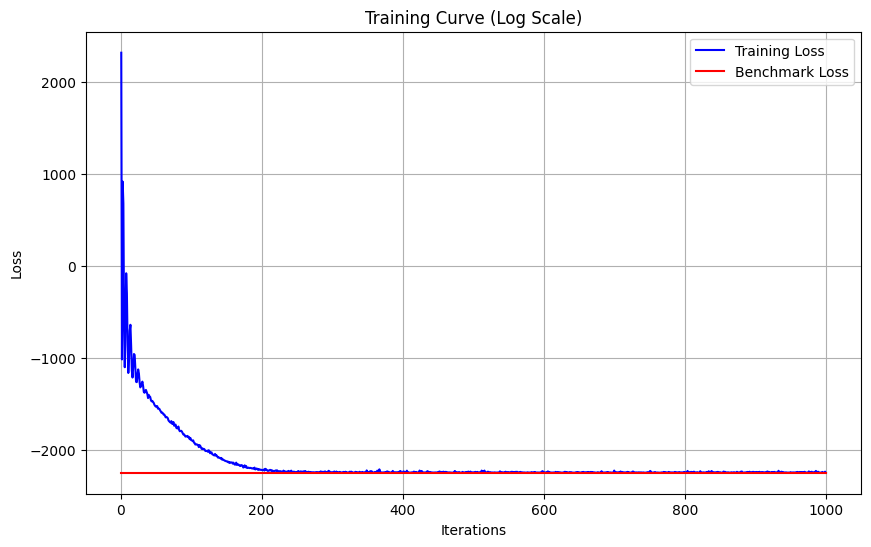

In [ ]:

loss_for_plot = np.array(loss_for_plot)
loss_for_plot_benchmark = np.array(loss_for_plot_benchmark)
iterations = np.arange(1, 1001)  # 1 to 15000 iterations
 # Example loss values (replace with your actual data)

# Create a log scale on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_for_plot, label='Training Loss', color='blue')
## add another line for benchmark loss
plt.plot(iterations, loss_for_plot_benchmark, label='Benchmark Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Curve (Log Scale)')
plt.grid(True)
plt.legend()
plt.show()

